# Mineração de Dados - 2018.2
----

## Dependências

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import groupby
from datetime import datetime
from sklearn.ensemble import IsolationForest

In [2]:
STR_FORMAT = '%Y-%m-%d %H:%M:%S'
rng = np.random.RandomState(42)

## Métodos Auxiliares

In [3]:

def get_date(ts):
    date = datetime.fromtimestamp(ts).strftime(STR_FORMAT)
    return date


def drop_invalid_columns(df):
    colsdrop = ['Unnamed: 0', 'VAR19', 'VAR29', 'VAR30']
    df = df.drop(colsdrop, axis=1)
    return df


def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop


def get_top_correlations(df, n=5, asc=False, absolute=False):
    au_corr = df.corr().abs().unstack() if absolute else df.corr().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=asc)
    return au_corr[0:n]


ranges = {}
def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        ranges[feature_name] = (min_value, max_value)
        
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

def denormalize(df):
    result = df.copy()
    for feature_name in df.columns:
        result[feature_name] = df[feature_name] * (ranges[feature_name][1] - ranges[feature_name][0]) + ranges[feature_name][0]
    return result

def get_anomalies(base, reprovados=False, contamination=0.1):
    # Base de dado sem headers
    sample = base.copy()
    sample.columns = range(sample.shape[1])
    
    #Isolation Forest
    clf = IsolationForest(behaviour='new', max_samples='auto', random_state=rng, 
                          contamination=contamination, n_jobs=-1)
    clf.fit(sample)
    
    # Deteccao de anomalias
    scores = clf.decision_function(sample)
    predict  = clf.predict(sample)
    num_outliers = predict.tolist().count(-1)
    
    outliers = []
    outliers_position = []
    while len(outliers) < num_outliers:
        outliers.append(scores.min())
        
        outliers_position.append(scores.argmin()+1)
        scores = np.delete(scores, scores.argmin())
    
    # Anomalias encontradas    
    anomalias = base.iloc[outliers_position]
    anomalias = anomalias.sort_values(
            by=['DESEMPENHO'],
            ascending=False
            )
    anomalias = anomalias.drop_duplicates()
    
    return anomalias

def anomalias_por_periodo(df_anomalia, title, ax):
    periodos = []
    for _, row in df_anomalia.iterrows():
        periodos.append(row["PERIODO"])

    periodos.sort()
    frequencia = [len(list(group)) for key, group in groupby(periodos)]
    periodos = list(set(periodos))
    
    ax.set_title(title)
    ax.set_xlabel('Período')
    ax.set_ylabel('Frequência')
    ax.set_xticks(np.arange(10))
    ax.bar(periodos, frequencia)

def bar_plot_series(serie, name, save=False):
    plt.figure(figsize=(20,10))
    serie.plot.bar()
    if save:
        plt.savefig('./Outputs/Figuras/'+name+'.svg', bbox_inches='tight')
        return
    plt.show()

def heatmap(df, title, ax):
    df = df.copy()
    df = df.drop("DESEMPENHO_BINARIO", axis=1)
    
    ax.set_title(title)
    corr = df.corr()
    sns.heatmap(
        corr,
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        cmap="YlGnBu",
        linewidth=0.5,
        vmin=-1,
        vmax=1,
        ax=ax)


## Modelagem
----

In [4]:
# Carregar Dados
curso = 'Pedagogia'
base = '../Base/Subsets/base{}.csv'.format(curso)
df_base = pd.read_csv(base, sep=';', decimal=',', index_col=False)
df_base = drop_invalid_columns(df_base)

In [5]:
# Registros por disciplina

df_disciplinas = []
disciplinas = list(df_base["NOME_DA_DISCIPLINA"].drop_duplicates())
for d in disciplinas:
    df_disci = df_base.loc[df_base["NOME_DA_DISCIPLINA"]==d]
    registros = len(df_disci)
    if registros != 0:
        df_disciplinas.append((registros, d))
        
df_disciplinas = pd.DataFrame(df_disciplinas, columns=["registros", "disciplina"])
df_disciplinas = df_disciplinas.sort_values(
        by=["registros"],
        ascending=False
        )
nome_disciplina = df_disciplinas.iat[0, 1]
df_disciplinas.head()

,registros,disciplina
22,871,Planejamento Educacional
19,788,Educação e Multiculturalismo
18,788,Currículo e Contemporaneidade
15,497,Movimentos Sociais
13,497,História da Educação no Brasil


In [6]:
# Seleção

df_base = df_base.sort_values(
        by=['DESEMPENHO'],
        ascending=False
        )

# Disciplina com mais registros
df_base = df_base.loc[df_base["NOME_DA_DISCIPLINA"]==nome_disciplina]
df_base.head(3)

,CURSO,SEMESTRE,PERIODO,NOME_DA_DISCIPLINA,ID_DA_DISCIPLINA,DATA_DE_INICIO,DATA_DE_FINAL,ID_DO_ALUNO,VAR01,VAR02,...,FORUM04,MEDIA_FORUM,WEBQUEST01,WEBQUEST02,MEDIA_WEBQUEST,DESEMPENHO,DESEMPENHO_BINARIO,MEDIA_CALCULADA_PROVA,MEDIA_CALCULADA_FORUM,TEMPO_DE_CURSO
13332,Pedagogia,2016.1,4,Planejamento Educacional,61,2015-12-31 21:00:00,2016-06-30 20:59:59,1709,18,1,...,5,2.0,6,6,3.0,10.5,0,5.5,5.00,181 days 23:59:59.000000000
13161,Pedagogia,2016.1,4,Planejamento Educacional,61,2015-12-31 21:00:00,2016-06-30 20:59:59,1715,23,2,...,5,2.0,6,6,3.0,10.5,0,5.5,5.00,181 days 23:59:59.000000000
13241,Pedagogia,2016.1,4,Planejamento Educacional,61,2015-12-31 21:00:00,2016-06-30 20:59:59,1652,18,0,...,5,1.9,6,6,3.0,10.4,0,5.5,4.75,181 days 23:59:59.000000000


In [7]:
print("Registros: Total -> {} | Possíveis Aprovados -> {} | Reprovados -> {}".format(
    len(df_base),
    len(df_base.loc[df_base["DESEMPENHO_BINARIO"] == 0]), 
    len(df_base.loc[df_base["DESEMPENHO_BINARIO"] == 1]))
     )

Registros: Total -> 871 | Possíveis Aprovados -> 324 | Reprovados -> 547


In [8]:
# Seleção das variáveis de interesse
df_clean = df_base[['VAR02', 'VAR03', 'VAR04','VAR06', 'VAR07', 'VAR16','VAR18', 'VAR20',
                   'VAR24', 'VAR31', 'VAR33', 'VAR34', 'PRIMEIRA_PROVA','SEGUNDA_PROVA', 'MEDIA_PROVAS', 
                   'FORUM01', 'FORUM02', 'FORUM03', 'FORUM04','MEDIA_FORUM', 'WEBQUEST01', 'WEBQUEST02', 
                   'MEDIA_WEBQUEST', 'DESEMPENHO', 'DESEMPENHO_BINARIO']]

# Correção de inconsistencias no cálculo de desempenho
df_clean['DESEMPENHO'] = df_clean['DESEMPENHO'].apply(lambda x: 10 if x>10 else x)
df_clean.head()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,VAR02,VAR03,VAR04,VAR06,VAR07,VAR16,VAR18,VAR20,VAR24,VAR31,...,FORUM01,FORUM02,FORUM03,FORUM04,MEDIA_FORUM,WEBQUEST01,WEBQUEST02,MEDIA_WEBQUEST,DESEMPENHO,DESEMPENHO_BINARIO
13332,1,0,12,0,0,0,22,0,5.0,140,...,5,5,5,5,2.0,6,6,3.00,10.0,0
13161,2,0,4,0,0,0,39,0,2.0,77,...,5,5,5,5,2.0,6,6,3.00,10.0,0
13241,0,0,0,0,0,0,36,0,3.0,93,...,4,5,5,5,1.9,6,6,3.00,10.0,0
13266,0,0,0,0,0,0,103,0,7.0,182,...,5,5,5,5,2.0,5,6,2.75,10.0,0
13439,1,0,4,0,0,0,30,0,4.0,111,...,5,5,5,5,2.0,6,6,3.00,10.0,0


## Análise
----

### - Normalização

In [9]:
df_clean_norm = normalize(df_clean)
df_clean_norm.head(3)

,VAR02,VAR03,VAR04,VAR06,VAR07,VAR16,VAR18,VAR20,VAR24,VAR31,...,FORUM01,FORUM02,FORUM03,FORUM04,MEDIA_FORUM,WEBQUEST01,WEBQUEST02,MEDIA_WEBQUEST,DESEMPENHO,DESEMPENHO_BINARIO
13332,0.25,0.0,0.151899,0.0,0.0,0.0,0.153846,0.0,0.384615,0.394366,...,1.0,1.0,1.0,1.0,1.00,1.0,1.0,1.0,1.0,0.0
13161,0.50,0.0,0.050633,0.0,0.0,0.0,0.272727,0.0,0.153846,0.216901,...,1.0,1.0,1.0,1.0,1.00,1.0,1.0,1.0,1.0,0.0
13241,0.00,0.0,0.000000,0.0,0.0,0.0,0.251748,0.0,0.230769,0.261972,...,0.8,1.0,1.0,1.0,0.95,1.0,1.0,1.0,1.0,0.0


### - Detecção de Anomalias

In [10]:
anomalias_norm = get_anomalies(df_clean_norm, contamination='auto')
print("Anomalias: Possíveis Aprovados -> {} | Reprovados -> {}".format(
    len(anomalias_norm.loc[anomalias_norm["DESEMPENHO_BINARIO"] == 0]), 
    len(anomalias_norm.loc[anomalias_norm["DESEMPENHO_BINARIO"] == 1]))
     )

Anomalias: Possíveis Aprovados -> 88 | Reprovados -> 37


## Visualização
----

In [11]:
# Remoção de anomalias no subset
idxc = df_clean_norm.index
idxa = anomalias_norm.index
idxs = idxc.difference(idxa)

df_clean_norm = df_clean_norm.loc[idxs]

### - Variaveis de Interesse
---
| Variável        | Significado | Categoria |
| --------------- | ----------- | --------- |
| VAR02           | Quantidade de mensagens enviadas por aluna(o) às(os) Professoras(es) pelo ambiente.  | Busca por Ajuda
| VAR03           | Quantidade de mensagens enviadas por aluna(o) às(os) Tutor(es) pelo ambiente.        | Busca por Ajuda
| VAR04           | Quantidade geral de mensagens enviadas pela(o) aluna(o) dentro do ambiente.          | Busca por Ajuda
| VAR06           | Quantidade de tópicos criados pelo(a) aluno(a) em fórum do tipo "tira-dúvidas".      | Busca por Ajuda
| VAR07           | Quantidade de postagens no "Fórum tira dúvidas".                                     | Busca por Ajuda
| VAR16           | Quantidade de atividades entregues por um(a) aluno(a) fora do prazo, por disciplina. | Estratégia de Realização de Tarefa
| VAR18           | Quantidade de leituras feitas ao fórum (pageviews).                                  | Estratégia de Realização de Tarefa
| VAR20           | Quantidade de respostas ao tópico principal (refazer opinião em fórum). | Autoavaliação
| VAR24           | Média semanal da quantidade de acessos de um(a) aluno(a) ao ambiente. | Gestão do Tempo
| VAR31           | Quantidade de acessos do(a) aluno(a) ao ambiente.                     | Gestão do Tempo
| VAR33           | Quantidade de atividades entregues por um(a) aluno(a) no prazo, por disciplina. | Estabelecimento de metas
| VAR34           | Quantidade geral de postagens de um(a) aluno(a) em fóruns.                      | Estabelecimento de metas
| PRIMEIRA_PROVA  | Nota da primeira prova ou da segunda chamada. | Provas Presenciais
| SEGUNDA_PROVA   | Nota da segunda prova ou da segunda chamada.  | Provas Presenciais
| MEDIA_PROVAS    | Media geral das duas provas presenciais.      | Provas Presenciais
| FORUM01         | Nota do primeiro fórum.        | Fóruns
| FORUM02         | Nota do segundo fórum.         | Fóruns
| FORUM03         | Nota do terceiro fórum.        | Fóruns
| FORUM04         | Nota do quarto fórum.          | Fóruns
| MEDIA_FORUM     | Média geral dos quatro fóruns. | Fóruns
| WEBQUEST01      | Nota da primeira atividade (webquest). | Atividades (WebQuest)
| WEBQUEST02      | Nota da segunda atividade (webquest).  | Atividades (WebQuest)
| MEDIA_WEBQUEST  | Média geral das duas atividades.       | Atividades (WebQuest)
| DESEMPENHO      | 0.55\*MEDIA_PROVAS + 0.2\*MEDIA_FORUM + 0.25\*MEDIA_WEBQUEST | Avaliação

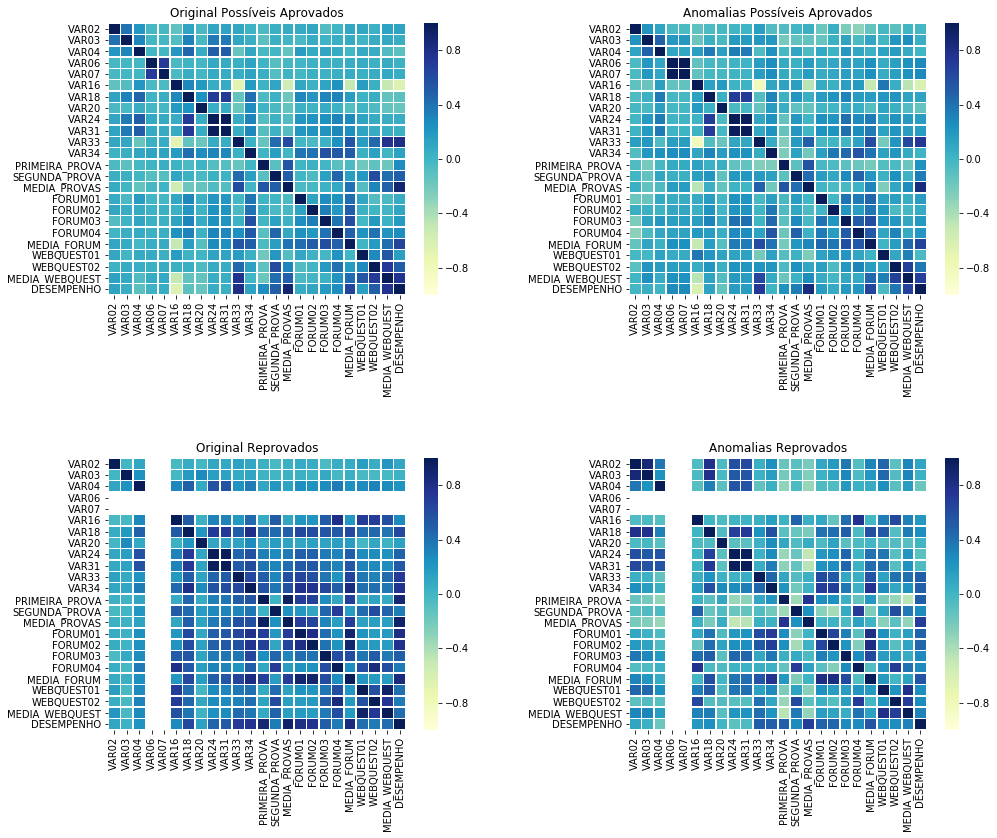

In [12]:
# Heatmap
f, (ax1, ax2) = plt.subplots(2, 2, figsize=(16,13))
plt.subplots_adjust(wspace=0.4, hspace=0.6)

heatmap(df_clean_norm.loc[df_clean_norm["DESEMPENHO_BINARIO"] == 0], "Original Possíveis Aprovados", ax1[0])
heatmap(anomalias_norm.loc[anomalias_norm["DESEMPENHO_BINARIO"] == 0], "Anomalias Possíveis Aprovados", ax1[1])

heatmap(df_clean_norm.loc[df_clean_norm["DESEMPENHO_BINARIO"] == 1], "Original Reprovados", ax2[0])
heatmap(anomalias_norm.loc[anomalias_norm["DESEMPENHO_BINARIO"] == 1], "Anomalias Reprovados", ax2[1])

### Análise das Anomalias

In [13]:
# Desnormalização
anomalias_denorm = denormalize(anomalias_norm)
anomalias_denorm.head(3)

,VAR02,VAR03,VAR04,VAR06,VAR07,VAR16,VAR18,VAR20,VAR24,VAR31,...,FORUM01,FORUM02,FORUM03,FORUM04,MEDIA_FORUM,WEBQUEST01,WEBQUEST02,MEDIA_WEBQUEST,DESEMPENHO,DESEMPENHO_BINARIO
13241,0.0,0.0,0.0,0.0,0.0,0.0,36.0,0.0,3.0,93.0,...,4.0,5.0,5.0,5.0,1.9,6.0,6.0,3.00,10.000,0.0
13266,0.0,0.0,0.0,0.0,0.0,0.0,103.0,0.0,7.0,182.0,...,5.0,5.0,5.0,5.0,2.0,5.0,6.0,2.75,10.000,0.0
13398,0.0,0.0,13.0,0.0,0.0,0.0,21.0,0.0,4.0,127.0,...,5.0,5.0,5.0,5.0,2.0,5.0,6.0,2.75,9.975,0.0


In [14]:
# Anomalias com dados completos

nome_disciplina = nome_disciplina.replace(' ', '')
df_anomalia = df_base.loc[anomalias_denorm.index]
df_anomalia.to_csv('../Base/Subsets/Anomalias/anomalias{}Disciplina{}.csv'.format(curso, nome_disciplina), sep=';', decimal=',')
df_anomalia.sort_values(
    by=["DESEMPENHO"], 
    ascending=False
    ).head(10)


,CURSO,SEMESTRE,PERIODO,NOME_DA_DISCIPLINA,ID_DA_DISCIPLINA,DATA_DE_INICIO,DATA_DE_FINAL,ID_DO_ALUNO,VAR01,VAR02,...,FORUM04,MEDIA_FORUM,WEBQUEST01,WEBQUEST02,MEDIA_WEBQUEST,DESEMPENHO,DESEMPENHO_BINARIO,MEDIA_CALCULADA_PROVA,MEDIA_CALCULADA_FORUM,TEMPO_DE_CURSO
13241,Pedagogia,2016.1,4,Planejamento Educacional,61,2015-12-31 21:00:00,2016-06-30 20:59:59,1652,18,0,...,5,1.9,6,6,3.00,10.400,0,5.500,4.75,181 days 23:59:59.000000000
13266,Pedagogia,2016.1,4,Planejamento Educacional,61,2015-12-31 21:00:00,2016-06-30 20:59:59,1731,54,0,...,5,2.0,5,6,2.75,10.250,0,5.500,5.00,181 days 23:59:59.000000000
13398,Pedagogia,2016.1,4,Planejamento Educacional,61,2015-12-31 21:00:00,2016-06-30 20:59:59,1775,8,0,...,5,2.0,5,6,2.75,9.975,0,5.225,5.00,181 days 23:59:59.000000000
13274,Pedagogia,2016.1,4,Planejamento Educacional,61,2015-12-31 21:00:00,2016-06-30 20:59:59,1769,6,0,...,5,2.0,5,6,2.75,9.975,0,5.225,5.00,181 days 23:59:59.000000000
13434,Pedagogia,2016.1,4,Planejamento Educacional,61,2015-12-31 21:00:00,2016-06-30 20:59:59,1740,7,0,...,5,2.0,4,5,2.25,9.750,0,5.500,5.00,181 days 23:59:59.000000000
13217,Pedagogia,2016.1,4,Planejamento Educacional,61,2015-12-31 21:00:00,2016-06-30 20:59:59,1799,8,0,...,5,1.9,6,5,2.75,9.600,0,4.950,4.75,181 days 23:59:59.000000000
13344,Pedagogia,2016.1,4,Planejamento Educacional,61,2015-12-31 21:00:00,2016-06-30 20:59:59,1905,7,0,...,5,2.0,4,4,2.00,9.225,0,5.225,5.00,181 days 23:59:59.000000000
13280,Pedagogia,2016.1,4,Planejamento Educacional,61,2015-12-31 21:00:00,2016-06-30 20:59:59,1686,44,0,...,5,2.0,4,5,2.25,9.200,0,4.950,5.00,181 days 23:59:59.000000000
13405,Pedagogia,2016.1,4,Planejamento Educacional,61,2015-12-31 21:00:00,2016-06-30 20:59:59,1793,4,0,...,5,2.0,5,5,2.50,9.175,0,4.675,5.00,181 days 23:59:59.000000000
13362,Pedagogia,2016.1,4,Planejamento Educacional,61,2015-12-31 21:00:00,2016-06-30 20:59:59,1914,6,0,...,5,1.5,4,5,2.25,8.975,0,5.225,3.75,181 days 23:59:59.000000000
